<a href="https://colab.research.google.com/github/Tonyussama/AI-Learning/blob/main/Another_copy_of_PFC_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install some necessary dependencies
!apt-get update > /dev/null
!apt-get install rustc > /dev/null
!apt-get install cargo > /dev/null
!pip install -q opengen > /dev/null

import opengen as og
import casadi.casadi as cs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [82]:
# Problem parameters
(nu, nx, N, L, ts) = (2, 3, 6, 0.5, 0.1)
a = 0.1  # Semi-major axis in x-direction
b = 2.0  # Semi-minor axis in y-direction
center_x = 0.0  # Ellipse center x
center_y = 0.0  # Ellipse center y
v_desired = 0.5  # Desired velocity along the path

# Weights for the cost function
(q, qtheta, r, qv) = (2000, 100, 5, 50)
position_continuity_weight = 1000
velocity_smoothness_weight = 100

# Define optimization variables
u = cs.SX.sym('u', nu*N)
z0 = cs.SX.sym('z0', nx)

# Initial state
(x, y, theta) = (z0[0], z0[1], z0[2])
x_prev = x
y_prev = y

# Cost function
cost = 0
for t in range(0, nu*N, nu):
    # Calculate relative position to ellipse center
    x_rel = x - center_x
    y_rel = y - center_y

    # Distance to ellipse calculation
    dist_to_ellipse = ((x_rel**2/a**2 + y_rel**2/b**2) - 1)

    # Compute tangential direction for counterclockwise movement
    dx = -a * np.sin(cs.arctan2(y_rel, x_rel))
    dy = b * np.cos(cs.arctan2(y_rel, x_rel))
    theta_desired = cs.arctan2(dy, dx)

    # Path following costs
    cost += q*dist_to_ellipse**2 + qtheta*(theta - theta_desired)**2

    # Control input and velocity tracking with direction
    u_t = u[t:t+2]
    v_current = cs.sqrt(u_t[0]**2 + u_t[1]**2)
    v_direction = (dx*u_t[0] + dy*u_t[1]) / (cs.sqrt(dx**2 + dy**2) * v_current + 1e-6)

    # Position-dependent velocity scaling
    y_normalized = y_rel/b
    v_target = v_desired * (1.0 - 0.3*cs.fabs(y_normalized))

    # Direction and velocity costs
    cost += r * cs.dot(u_t, u_t) + qv*(v_current - v_target)**2 + 50*(1 - v_direction)

    # Position and velocity continuity
    if t > 0:
        # Position continuity
        dx_step = x - x_prev
        dy_step = y - y_prev
        step_size = cs.sqrt(dx_step**2 + dy_step**2)
        cost += position_continuity_weight * cs.fmax(step_size - v_desired*ts, 0)**2

        # Velocity continuity
        prev_u = u[t-2:t]
        velocity_change = cs.sumsqr(u_t - prev_u)
        cost += velocity_smoothness_weight * velocity_change

    # Store current position
    x_prev = x
    y_prev = y

    # System dynamics
    theta_dot = (1/L) * (u_t[1] * cs.cos(theta) - u_t[0] * cs.sin(theta))
    x += ts * (u_t[0] + L * cs.sin(theta) * theta_dot)
    y += ts * (u_t[1] - L * cs.cos(theta) * theta_dot)
    theta += ts * theta_dot

# Control constraints
umin = [-3.0] * (nu*N)
umax = [3.0] * (nu*N)
bounds = og.constraints.Rectangle(umin, umax)

In [83]:
# Rest of the optimizer building code remains the same
problem = og.builder.Problem(u, z0, cost).with_constraints(bounds)
build_config = og.config.BuildConfiguration() \
    .with_build_directory("my_optimizers") \
    .with_build_mode("debug") \
    .with_tcp_interface_config() \
    .with_build_python_bindings()
meta = og.config.OptimizerMeta() \
    .with_optimizer_name("ellipse_nav15")
solver_config = og.config.SolverConfiguration() \
    .with_tolerance(1e-5)
builder = og.builder.OpEnOptimizerBuilder(problem,
                                          meta,
                                          build_config,
                                          solver_config)
builder.build()

[INFO] --- Initialising builder: 'ellipse_nav15'
INFO:opengen.builder.OpEnOptimizerBuilder:--- Initialising builder: 'ellipse_nav15'
[INFO] Checking user parameters
INFO:opengen.builder.OpEnOptimizerBuilder:Checking user parameters
[INFO] Creating necessary folders
INFO:opengen.builder.OpEnOptimizerBuilder:Creating necessary folders
[INFO] Copying icasadi interface to target directory
INFO:opengen.builder.OpEnOptimizerBuilder:Copying icasadi interface to target directory
[INFO] Generating icasadi's Cargo.toml
INFO:opengen.builder.OpEnOptimizerBuilder:Generating icasadi's Cargo.toml
[INFO] Generating Cargo.toml for target optimizer
INFO:opengen.builder.OpEnOptimizerBuilder:Generating Cargo.toml for target optimizer
[INFO] Generating icasadi Rust library file
INFO:opengen.builder.OpEnOptimizerBuilder:Generating icasadi Rust library file
[INFO] Defining CasADi functions and generating C code
INFO:opengen.builder.OpEnOptimizerBuilder:Defining CasADi functions and generating C code
[INFO] D

{'meta': {'name': 'ellipse_nav15',
  'version': '0.0.0',
  'author': ['John Smith'],
  'licence': 'MIT'},
 'problem': {'dim_decision_variables': 12,
  'dim_parameters': 3,
  'dim_constraints_penalty': 0,
  'dim_constraints_aug_lagrangian': 0},
 'build_config': {'target_system': None,
  'build_mode': 'debug',
  'rebuild': False,
  'build_directory': 'my_optimizers',
  'open_version': None,
  'build_c_bindings': False,
  'build_python_bindings': True,
  'tcp_interface_config': {'ip': '127.0.0.1', 'port': 8333}},
 'solver_config': {'tolerance': 1e-05,
  'initial_tolerance': 0.0001,
  'lbfgs_memory': 10,
  'max_inner_iterations': 500,
  'max_outer_iterations': 10,
  'constraints_tolerance': 0.0001,
  'initial_penalty': None,
  'penalty_weight_update_factor': 5.0,
  'max_duration_micros': 5000000,
  'inner_tolerance_update_factor': 0.1,
  'sufficient_decrease_coefficient': 0.1,
  'cbfgs_alpha': None,
  'cbfgs_epsilon': None,
  'cbfgs_sy_epsilon': None,
  'do_preconditioning': False},
 'path

In [84]:
# Import and use the optimizer
import sys
sys.path.insert(1, '/content/my_optimizers/ellipse_nav15')
import ellipse_nav15

In [85]:
def mpc_controller(state):
    solver = ellipse_nav15.solver()
    # Create initial guess promoting counterclockwise motion
    initial_guess = []
    angle = np.arctan2(state[1], state[0])
    for _ in range(N):
        vx = -v_desired * np.sin(angle)
        vy = v_desired * np.cos(angle)
        initial_guess.extend([vx, vy])
    result = solver.run(p=state, initial_guess=initial_guess)
    return result.solution

def system_dynamics(x, u):
    x_new = np.zeros(3)
    theta_dot = (1/L) * (u[1] * np.cos(x[2]) - u[0] * np.sin(x[2]))
    x_new[0] = x[0] + ts * (u[0] + L * np.sin(x[2]) * theta_dot)
    x_new[1] = x[1] + ts * (u[1] - L * np.cos(x[2]) * theta_dot)
    x_new[2] = x[2] + ts * theta_dot
    return x_new

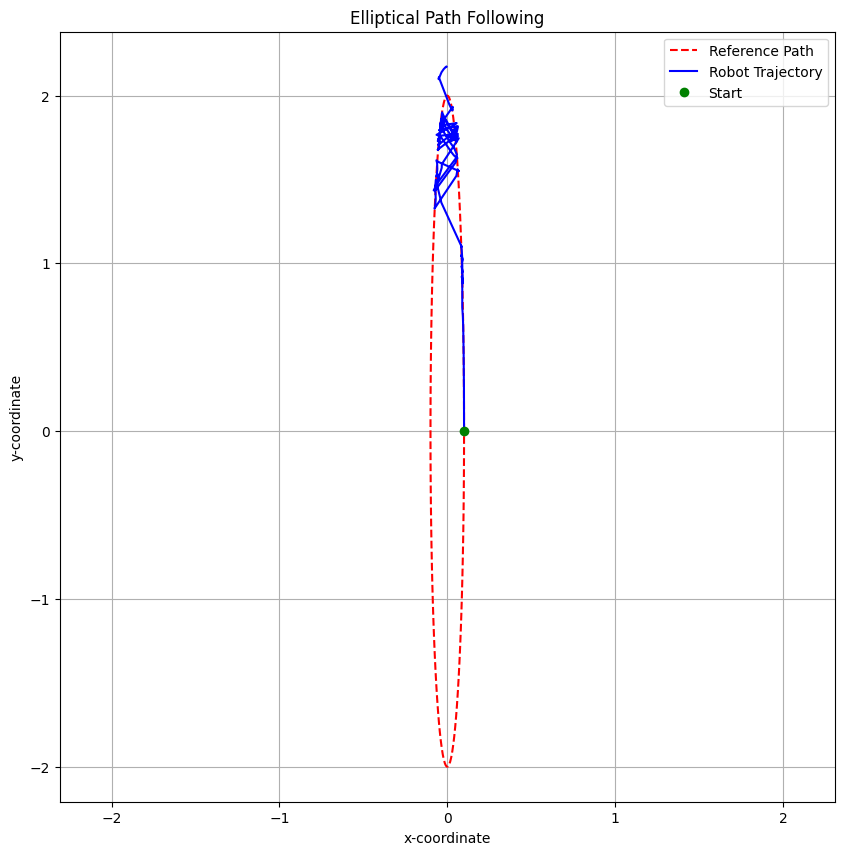

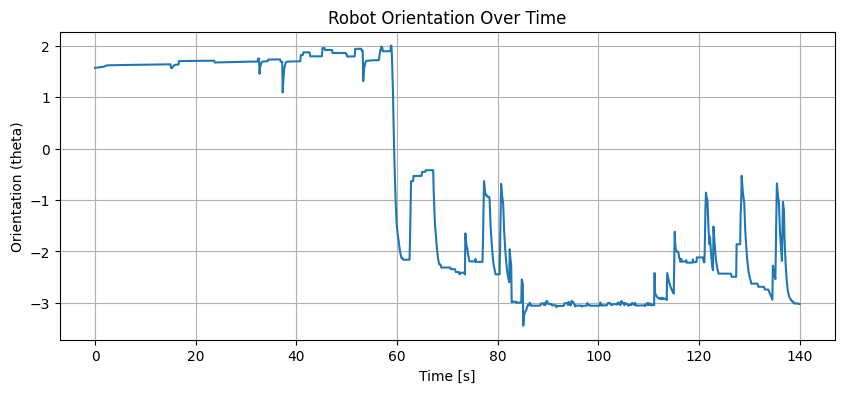

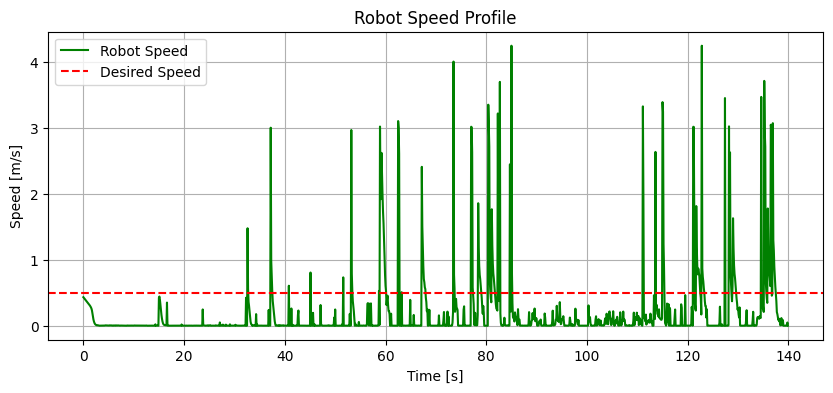

In [86]:
# Simulation
Nsim = 1400
x_cache = np.zeros((nx, Nsim + 1))
x_cache[:, 0] = np.array([a, 0.0, np.pi/2]) # Start on ellipse

# Speed storage
speeds = np.zeros(Nsim + 1)

# Main simulation loop
for t in range(Nsim):
    x_current = x_cache[:, t]
    u_mpc = mpc_controller(x_current)
    next_state = system_dynamics(x_current, u_mpc[0:2])
    x_cache[:, t + 1] = next_state
    speeds[t] = np.sqrt(u_mpc[0]**2 + u_mpc[1]**2)

# Plotting
time = np.arange(0, ts * (Nsim + 1), ts)

# Plot 1: Trajectory
plt.figure(figsize=(10, 10))
# Plot reference ellipse
t = np.linspace(0, 2*np.pi, 100)
ellipse_x = center_x + a*np.cos(t)
ellipse_y = center_y + b*np.sin(t)
plt.plot(ellipse_x, ellipse_y, '--r', label='Reference Path')

# Plot robot trajectory
plt.plot(x_cache[0, :], x_cache[1, :], '-b', label='Robot Trajectory')
plt.plot(x_cache[0, 0], x_cache[1, 0], 'go', label='Start')
plt.axis('equal')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Elliptical Path Following')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Orientation
plt.figure(figsize=(10, 4))
plt.plot(time, x_cache[2, :])
plt.xlabel('Time [s]')
plt.ylabel('Orientation (theta)')
plt.title('Robot Orientation Over Time')
plt.grid(True)
plt.show()

# Plot 3: Speed
plt.figure(figsize=(10, 4))
plt.plot(time[:-1], speeds[:-1], 'g-', label='Robot Speed')
plt.axhline(y=v_desired, color='r', linestyle='--', label='Desired Speed')
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Robot Speed Profile')
plt.legend()
plt.grid(True)
plt.show()

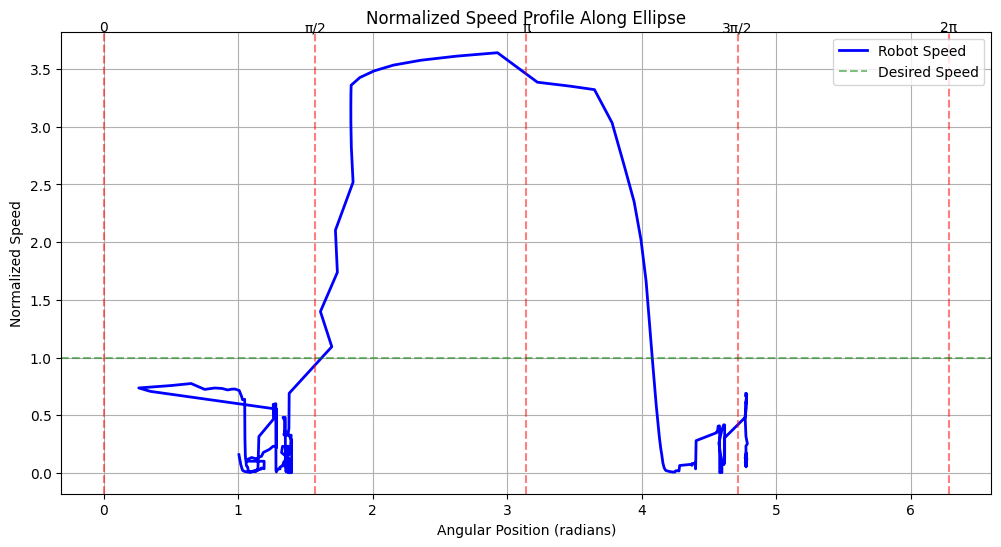

In [80]:
# Calculate angles and speeds
angles = np.zeros(Nsim)
speeds = np.zeros(Nsim)

for t in range(Nsim):
    # Calculate angle from center to robot position
    angles[t] = np.arctan2(x_cache[1, t], x_cache[0, t])
    if angles[t] < 0:
        angles[t] += 2*np.pi

    # Calculate speed at each point
    u_mpc = mpc_controller(x_cache[:, t])
    speeds[t] = np.sqrt(u_mpc[0]**2 + u_mpc[1]**2)

# Apply moving average filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth and normalize the speeds
window_size = 20
speeds_smooth = moving_average(speeds, window_size)
angles_smooth = angles[window_size-1:]
speeds_smooth_normalized = speeds_smooth / v_desired

# Create the speed vs angle plot
plt.figure(figsize=(12, 6))
plt.plot(angles_smooth, speeds_smooth_normalized, 'b-', linewidth=2, label='Robot Speed')
plt.xlabel('Angular Position (radians)')
plt.ylabel('Normalized Speed')
plt.title('Normalized Speed Profile Along Ellipse')
plt.grid(True)

# Add vertical lines at key angles
key_angles = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
key_labels = ['0', 'π/2', 'π', '3π/2', '2π']
for angle, label in zip(key_angles, key_labels):
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
    plt.text(angle, plt.ylim()[1], label, horizontalalignment='center')

plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.5, label='Desired Speed')
plt.legend()
plt.show()